In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns
plt.style.use('ggplot')

import datetime as dt
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import optuna.integration.lightgbm as optuna_lgb
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


# BestScore

In [55]:
#yearを除外する：77.72→76.8
#seasonを正しい振り分けにする：76.8→75.98
#tourist_areaとcategoryをcategory変数化：75.98→75.36
#arraivals_meanをcategory_areaに変更：75.36→75.19(RMSE:56)
#weather_lag1:75.19→74.59

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
index_mean_list = ['dayofweek']
for feature in index_mean_list:
    train_index_mean = train_df.groupby(feature)['tourism_index'].mean()
    train_df[f'{feature}_index_mean'] = train_df[feature].map(train_index_mean)
    test_index_mean = test_df.groupby(feature)['tourism_index'].mean()
    test_df[f'{feature}index_mean'] = test_df[feature].map(test_index_mean)

#weather_lag1
weather_obj = train_df.groupby(['date'])['weather_index'].mean().shift(1).reset_index()
weather_obj.rename(columns={'weather_index': f'weather_lag'}, inplace=True)
train_df = pd.merge(train_df, weather_obj, how='left', on='date')
train_df.drop('weather_index',axis=1,inplace=True)

weather_obj = test_df.groupby(['date'])['weather_index'].mean().shift(1).reset_index()
weather_obj.rename(columns={'weather_index': f'weather_lag'}, inplace=True)
test_df = pd.merge(test_df, weather_obj, how='left', on='date')
test_df.drop('weather_index',axis=1,inplace=True)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()
category_list += ['tourist_area', 'category']

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    le_train = LabelEncoder()
    le_train = le_train.fit(train_df[cat])

    train_df[cat] = le_train.transform(train_df[cat])
    test_df[cat] = le_train.transform(test_df[cat])

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


# Test

In [75]:
#tourism_lag:74.59

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

#tourism_indexの平均値
index_mean_list = ['dayofweek']
for feature in index_mean_list:
    train_index_mean = train_df.groupby(feature)['tourism_index'].mean()
    train_df[f'{feature}_index_mean'] = train_df[feature].map(train_index_mean)
    test_index_mean = test_df.groupby(feature)['tourism_index'].mean()
    test_df[f'{feature}_index_mean'] = test_df[feature].map(test_index_mean)

#tourism_lag
tourism_obj = train_df.groupby(['date','tourist_area'])['tourism_index'].mean().shift(1).reset_index()
tourism_obj.rename(columns={'tourism_index': 'tourism_lag'}, inplace=True)
train_df = pd.merge(train_df, tourism_obj, how='left', on=['date','tourist_area'])
#train_df.drop('tourism_lag',axis=1,inplace=True)

tourism_obj = test_df.groupby(['date','tourist_area'])['tourism_index'].mean().shift(1).reset_index()
tourism_obj.rename(columns={'tourism_index': 'tourism_lag'}, inplace=True)
test_df = pd.merge(test_df, tourism_obj, how='left', on=['date','tourist_area'])
#test_df.drop('tourism_lag',axis=1,inplace=True)

#weather_lag
weather_obj = train_df.groupby(['date'])['weather_index'].mean().shift(1).reset_index()
weather_obj.rename(columns={'weather_index': f'weather_lag'}, inplace=True)
train_df = pd.merge(train_df, weather_obj, how='left', on='date')
train_df.drop('weather_index',axis=1,inplace=True)

weather_obj = test_df.groupby(['date'])['weather_index'].mean().shift(1).reset_index()
weather_obj.rename(columns={'weather_index': f'weather_lag'}, inplace=True)
test_df = pd.merge(test_df, weather_obj, how='left', on='date')
test_df.drop('weather_index',axis=1,inplace=True)


#カテゴリ化(label encoding)
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()
category_list += ['tourist_area', 'category']

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    le_train = LabelEncoder()
    le_train = le_train.fit(train_df[cat])

    train_df[cat] = le_train.transform(train_df[cat])
    test_df[cat] = le_train.transform(test_df[cat])

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


# モデル学習(パラメータチューニングなし)

In [65]:
# 目的変数と説明変数の設定 ###############################
y_train = train_df[['tourist_arrivals']]
x_train = train_df.drop(['id', 'date'], axis=1)
x_test = test_df.drop(['id', 'date'], axis=1)
category_list = x_train.columns[x_train.dtypes=='category'].values.tolist()
arrival_mean_list = ['spot_facility','area']

# ーーーー 交差検証(CV) ーーーー
# 学習データ：2018年8月1日 〜 2019年5月31日、検証データ：それぞれの月（評価データと同じ条件）
# 評価データ : 2019年7月1日 〜 2019年7月31日

# 学習用と検証用のRMSEを追加するリスト
train_list = []
val_list = []

# 学習後のモデルを格納するリスト
models = []

month_index = x_train['month'].unique()   # 各月の数字を取得
for i, m in enumerate(month_index, 1):
    # 検証データの設定
    val_index = x_train[x_train["month"] == m].index   # インデックスを取得
    val_x_df = x_train.iloc[val_index]
    val_y_df = y_train.iloc[val_index]
    # 学習データの設定
    train_x_df = x_train.drop(val_index)   # 検証データのインデックスを落とす
    train_y_df = y_train.drop(val_index)

    # 目的変数に関する特徴量の追加(リークを避けるためにここで追加)
    # arrivals_mean_listごとの目的変数の平均値
    for feature in arrival_mean_list:
        train_obj = train_x_df.groupby(feature)['tourist_arrivals'].mean()   # 学習データの目的変数に関して求める
        train_x_df[f'arrivals_{feature}_mean'] = train_x_df[feature].map(train_obj)
        val_x_df[f'arrivals_{feature}_mean'] = val_x_df[feature].map(train_obj)
        x_test[f'arrivals_{feature}_mean'] = x_test[feature].map(train_obj)

    # 目的変数を落とす
    train_x_df = train_x_df.drop(['tourist_arrivals'], axis=1)
    val_x_df = val_x_df.drop(['tourist_arrivals'], axis=1)

    # パラメータ
    lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',

    'learning_rate': 0.05,
    'n_estimators': 3000,
    'importance_type': 'gain',

    'num_leaves': 32,

    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 20,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,

    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,

    'random_seed': 42  # 乱数設定
    }

    # LightGBMREgressor()インスタンスの生成
    model = lgb.LGBMRegressor(**lgbm_params)

    # モデルのfitting
    model.fit(train_x_df, train_y_df,
              eval_set = [(train_x_df, train_y_df), (val_x_df, val_y_df)],
              early_stopping_rounds = 50,
              categorical_feature = category_list,
              verbose = -1
              )

    #作成したモデルの格納
    models.append(model)

    # predict
    y_pred_train_hold = model.predict(train_x_df, num_iteration=model.best_iteration_)
    y_pred_valid_hold = model.predict(val_x_df, num_iteration=model.best_iteration_)

    # RMSEを算出
    temp_rmse_train = np.sqrt(mean_squared_error(train_y_df, y_pred_train_hold))
    temp_rmse_valid = np.sqrt(mean_squared_error(val_y_df, y_pred_valid_hold))

    # RMSEの表示
    print(f'RMSE(train_data) = {temp_rmse_train:.4f}')
    print(f'RMSE(valid_data) = {temp_rmse_valid:.4f}\n')

    # 学習用データと検証用データのリスト
    train_list.append(temp_rmse_train)
    val_list.append(temp_rmse_valid)

    # 評価データで、実際に予測
    preds_test = model.predict(x_test, num_iteration=model.best_iteration_)
    preds_test_np = np.array(preds_test)

    # 予測値を出力
    submission_cv['tourist_arrivals' + '_model' + str(i)] = preds_test_np

# 学習用データと検証用データの予測精度を出力
for i,m in enumerate(month_index):
    print(f'検証データ{m}月: RMSE(train_data) = {train_list[i]:.4f}, RMSE(valid_data) = {val_list[i]:.4f}')
print(f'train_fold_mean: {np.mean(train_list):.4f}, valid_fold_mean: {np.mean(val_list):.4f}')


[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
RMSE(train_data) = 58.0956
RMSE(valid_data) = 98.1737

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] min_d

# モデル学習(パラメータチューニングあり)

In [ ]:
#max_depth = 13 : 73.45

# 目的変数と説明変数の設定 ###############################
y_train = train_df[['tourist_arrivals']]
x_train = train_df.drop(['id', 'date'], axis=1)
x_test = test_df.drop(['id', 'date'], axis=1)
category_list = x_train.columns[x_train.dtypes=='category'].values.tolist()
arrival_mean_list = ['spot_facility','area']

# ーーーー 交差検証(CV) ーーーー
# 学習データ：2018年8月1日 〜 2019年5月31日、検証データ：それぞれの月（評価データと同じ条件）
# 評価データ : 2019年7月1日 〜 2019年7月31日

# 学習用と検証用のRMSEを追加するリスト
train_list = []
val_list = []

# 学習後のモデルを格納するリスト
models = []
params = []

month_index = x_train['month'].unique()   # 各月の数字を取得
for i, m in enumerate(month_index, 1):
    # 検証データの設定
    val_index = x_train[x_train["month"] == m].index   # インデックスを取得
    val_x_df = x_train.iloc[val_index]
    val_y_df = y_train.iloc[val_index]
    # 学習データの設定
    train_x_df = x_train.drop(val_index)   # 検証データのインデックスを落とす
    train_y_df = y_train.drop(val_index)

    # 目的変数に関する特徴量の追加(リークを避けるためにここで追加)
    # arrivals_mean_listごとの目的変数の平均値
    for feature in arrival_mean_list:
        train_obj = train_x_df.groupby(feature)['tourist_arrivals'].mean()   # 学習データの目的変数に関して求める
        train_x_df[f'arrivals_{feature}_mean'] = train_x_df[feature].map(train_obj)
        val_x_df[f'arrivals_{feature}_mean'] = val_x_df[feature].map(train_obj)
        x_test[f'arrivals_{feature}_mean'] = x_test[feature].map(train_obj)

    # 目的変数を落とす
    train_x_df = train_x_df.drop(['tourist_arrivals'], axis=1)
    val_x_df = val_x_df.drop(['tourist_arrivals'], axis=1)

    # optuna用に格納
    train_ds = lgb.Dataset(train_x_df, train_y_df)
    val_ds = lgb.Dataset(val_x_df, val_y_df)

    # パラメータ
    lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',

    'learning_rate': 0.05,
    'n_estimators': 3000,
    'importance_type': 'gain',

    'max_depth': 13,
    'random_seed': 42  # 乱数設定
    }

    # optunaによるパラメータチューニング
    opt = optuna_lgb.train(
        lgbm_params, train_ds, valid_sets=val_ds,
        verbose_eval = False,
        num_boost_round=100,
        early_stopping_rounds = 50,
        show_progress_bar=False,
        optuna_seed=42
        )

    # LightGBMREgressor()インスタンスの生成
    model = lgb.LGBMRegressor(**opt.params)
    model = model.fit(train_x_df, train_y_df,
        eval_set = [(train_x_df, train_y_df), (val_x_df, val_y_df)],
        early_stopping_rounds = 50,
        categorical_feature = category_list,
        verbose = -1
        )

    #作成したモデルの格納
    models.append(model)
    params.append(opt.params)

    # predict
    y_pred_train_hold = model.predict(train_x_df, num_iteration=model.best_iteration_)
    y_pred_valid_hold = model.predict(val_x_df, num_iteration=model.best_iteration_)

    # RMSEを算出
    temp_rmse_train = np.sqrt(mean_squared_error(train_y_df, y_pred_train_hold))
    temp_rmse_valid = np.sqrt(mean_squared_error(val_y_df, y_pred_valid_hold))

    # RMSEの表示
    print(f'RMSE(train_data) = {temp_rmse_train:.4f}')
    print(f'RMSE(valid_data) = {temp_rmse_valid:.4f}\n')

    # 学習用データと検証用データのリスト
    train_list.append(temp_rmse_train)
    val_list.append(temp_rmse_valid)

    # 評価データで、実際に予測
    preds_test = model.predict(x_test, num_iteration=model.best_iteration_)
    preds_test_np = np.array(preds_test)

    # 予測値を出力
    submission_cv['tourist_arrivals' + '_model' + str(i)] = preds_test_np

In [ ]:
# 学習用データと検証用データの予測精度を出力
for i,m in enumerate(month_index):
    print(f'検証データ{m}月: RMSE(train_data) = {train_list[i]:.4f}, RMSE(valid_data) = {val_list[i]:.4f}')
print(f'train_fold_mean: {np.mean(train_list):.4f}, valid_fold_mean: {np.mean(val_list):.4f}')


# optunaパラメータ前提の学習

In [52]:
# 目的変数と説明変数の設定 ###############################
y_train = train_df[['tourist_arrivals']]
x_train = train_df.drop(['id', 'date'], axis=1)
x_test = test_df.drop(['id', 'date'], axis=1)
category_list = x_train.columns[x_train.dtypes=='category'].values.tolist()
arrival_mean_list = ['spot_facility','area']

# ーーーー 交差検証(CV) ーーーー
# 学習データ：2018年8月1日 〜 2019年5月31日、検証データ：それぞれの月（評価データと同じ条件）
# 評価データ : 2019年7月1日 〜 2019年7月31日

# 学習用と検証用のRMSEを追加するリスト
train_list = []
val_list = []

# 学習後のモデルを格納するリスト
models = []

month_index = x_train['month'].unique()   # 各月の数字を取得
for i, m in enumerate(month_index, 1):
    # 検証データの設定
    val_index = x_train[x_train["month"] == m].index   # インデックスを取得
    val_x_df = x_train.iloc[val_index]
    val_y_df = y_train.iloc[val_index]
    # 学習データの設定
    train_x_df = x_train.drop(val_index)   # 検証データのインデックスを落とす
    train_y_df = y_train.drop(val_index)

    # 目的変数に関する特徴量の追加(リークを避けるためにここで追加)
    # arrivals_mean_listごとの目的変数の平均値
    for feature in arrival_mean_list:
        train_obj = train_x_df.groupby(feature)['tourist_arrivals'].mean()   # 学習データの目的変数に関して求める
        train_x_df[f'arrivals_{feature}_mean'] = train_x_df[feature].map(train_obj)
        val_x_df[f'arrivals_{feature}_mean'] = val_x_df[feature].map(train_obj)
        x_test[f'arrivals_{feature}_mean'] = x_test[feature].map(train_obj)

    # 目的変数を落とす
    train_x_df = train_x_df.drop(['tourist_arrivals'], axis=1)
    val_x_df = val_x_df.drop(['tourist_arrivals'], axis=1)

    # LightGBMREgressor()インスタンスの生成
    model = lgb.LGBMRegressor(**params[i-1])

    # モデルのfitting
    model.fit(train_x_df, train_y_df,
              eval_set = [(train_x_df, train_y_df), (val_x_df, val_y_df)],
              early_stopping_rounds = 50,
              categorical_feature = category_list,
              verbose = -1
              )

    #作成したモデルの格納
    models.append(model)

    # predict
    y_pred_train_hold = model.predict(train_x_df, num_iteration=model.best_iteration_)
    y_pred_valid_hold = model.predict(val_x_df, num_iteration=model.best_iteration_)

    # RMSEを算出
    temp_rmse_train = np.sqrt(mean_squared_error(train_y_df, y_pred_train_hold))
    temp_rmse_valid = np.sqrt(mean_squared_error(val_y_df, y_pred_valid_hold))

    # RMSEの表示
    print(f'RMSE(train_data) = {temp_rmse_train:.4f}')
    print(f'RMSE(valid_data) = {temp_rmse_valid:.4f}\n')

    # 学習用データと検証用データのリスト
    train_list.append(temp_rmse_train)
    val_list.append(temp_rmse_valid)

    # 評価データで、実際に予測
    preds_test = model.predict(x_test, num_iteration=model.best_iteration_)
    preds_test_np = np.array(preds_test)

    # 予測値を出力
    submission_cv['tourist_arrivals' + '_model' + str(i)] = preds_test_np


[LightGBM] [Warning] lambda_l1 is set=0.00013194449312775512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013194449312775512
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.47188117863746926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47188117863746926
[LightGBM] [Warning] lambda_l2 is set=1.1323342574941986e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1323342574941986e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
RMSE(train_data) = 83.1186
RMSE(valid_data) = 90.7418

[LightGBM] [Warning] lambda_l1 is set=3.378723712962024e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.378723712962024e-06
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.89999

In [ ]:
# 学習用データと検証用データの予測精度を出力
for i,m in enumerate(month_index):
    print(f'検証データ{m}月: RMSE(train_data) = {train_list[i]:.4f}, RMSE(valid_data) = {val_list[i]:.4f}')
print(f'train_fold_mean: {np.mean(train_list):.4f}, valid_fold_mean: {np.mean(val_list):.4f}')


# submit

In [46]:
# 交差検証で得た各モデルの評価データに対する予測値の平均値を書き込む ###############################
model_list = submission_cv.columns.tolist()
model_list.remove('id')
index = len(submission_cv['id'])
mean = []

for i in range(index):
    temp = 0
    for j in model_list:
        temp = temp + submission_cv[j][i]
    temp = temp / len(model_list)   # モデルの数で割る
    mean.append(temp)
mean_np = np.array(mean)
submission['tourist_arrivals'] = mean_np

# 予測値の書き込み
submission.to_csv('submission_pre.csv', index=False)
submission


,id,tourist_arrivals
0,145584,441.834624
1,145585,861.495859
2,145586,186.164245
3,145587,170.307595
4,145588,36.158405
...,...,...
13387,158971,266.802374
13388,158972,62.407705
13389,158973,434.748722
13390,158974,53.613276


# モデル結果検証用

In [ ]:
# importance
for i in range(len(models)):
    lgb.plot_importance(models[i])

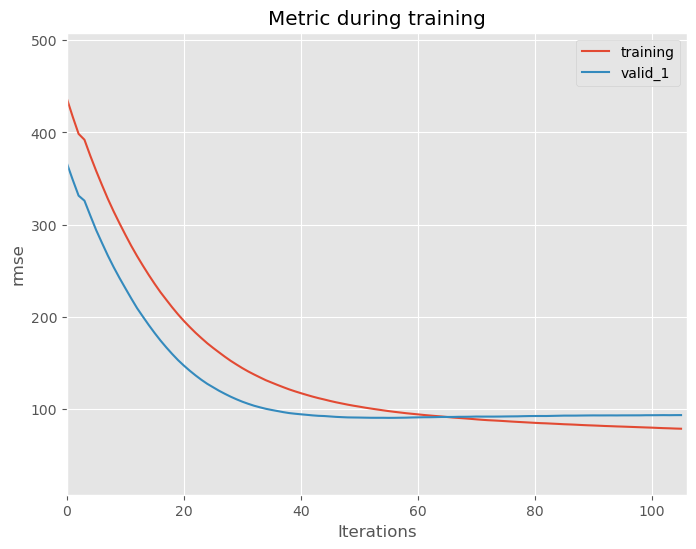

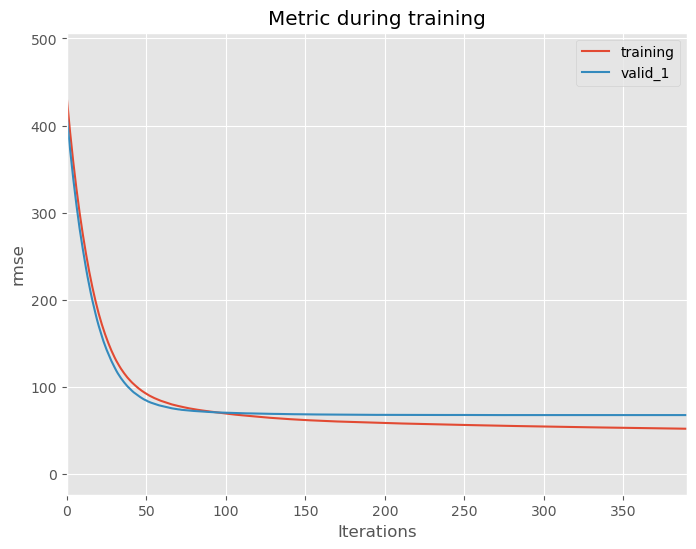

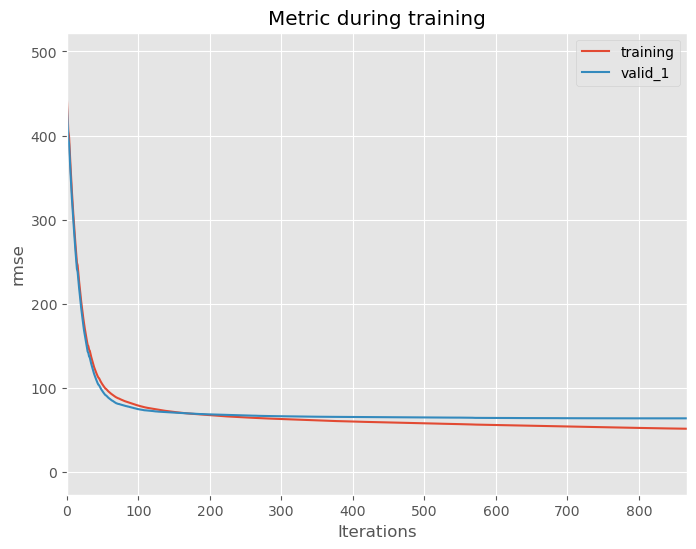

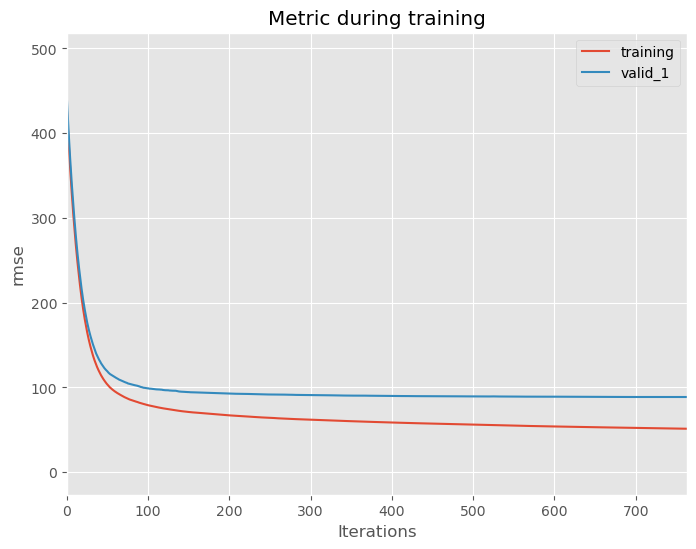

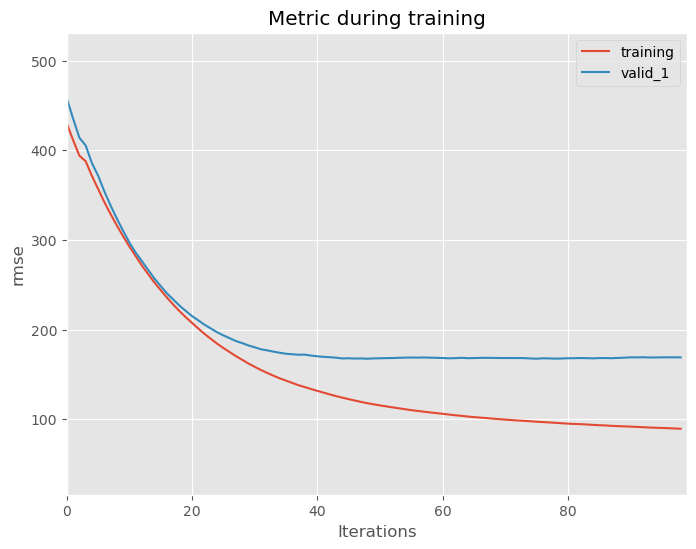

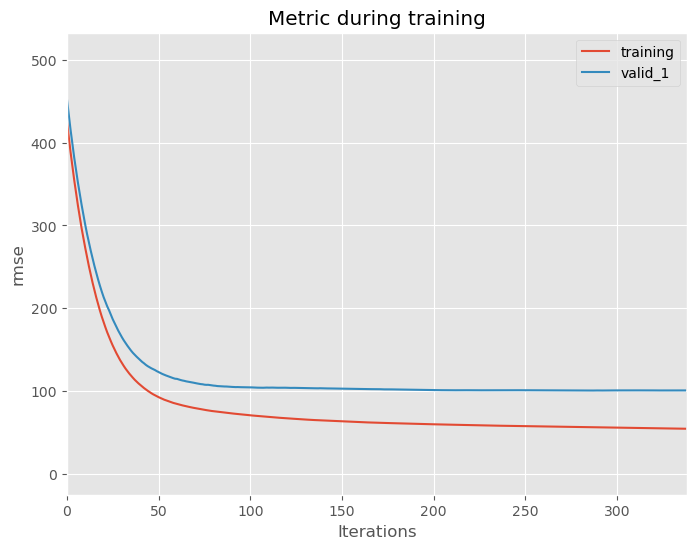

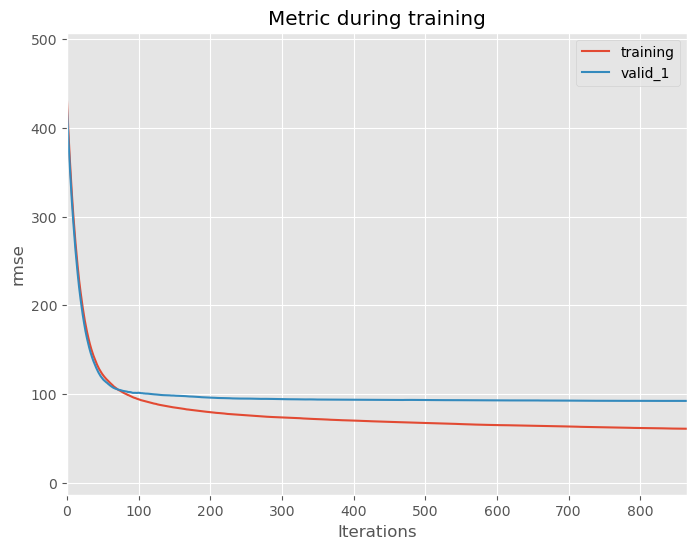

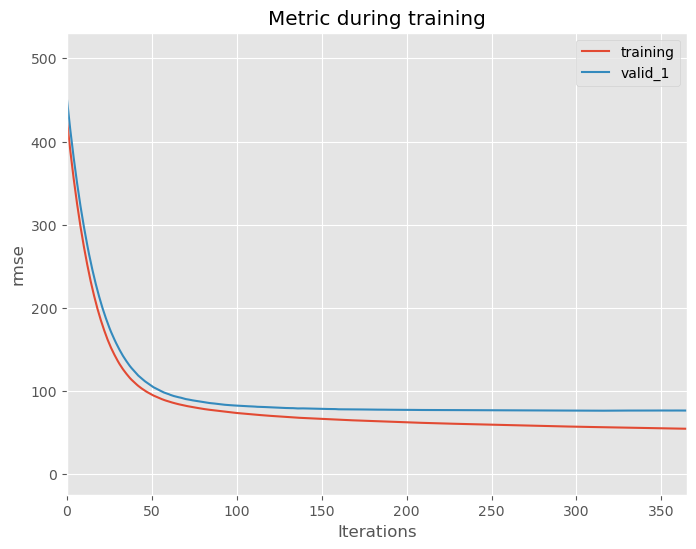

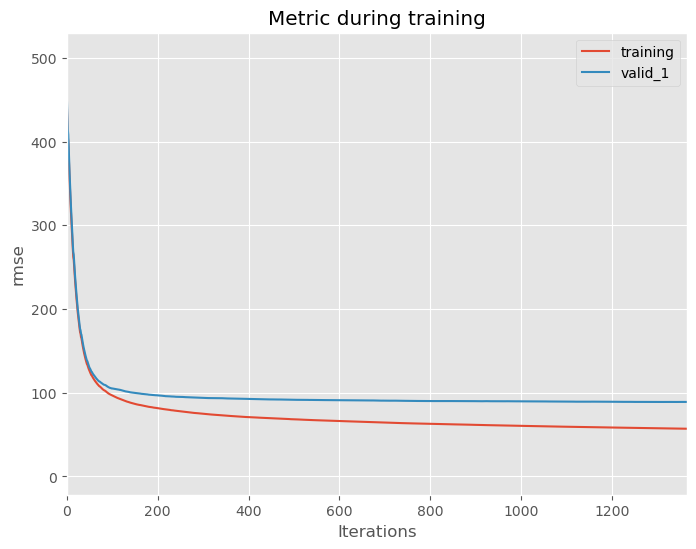

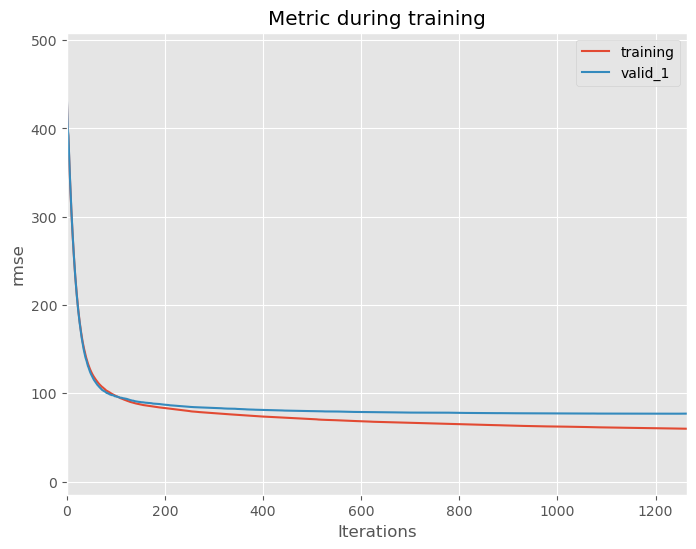

In [214]:
# 学習曲線の描画
for i in range(len(models)):
    ax = lgb.plot_metric(models[i].evals_result_, metric='rmse',figsize=(8, 6))
    plt.show()


# EDA

In [212]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# dateから、year, month, dayの情報を生成
# 訓練データ
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek
train_df['year_month'] = train_df['date'].dt.strftime('%Y-%m')
train_df['day_week'] = train_df['date'].dt.strftime('%d-%a')

# 予測対象データ
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek
test_df['year_month'] = test_df['date'].dt.strftime('%Y-%m')
test_df['day_week'] = test_df['date'].dt.strftime('%d-%a')

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)


In [ ]:
# 季節別のtourist_arrivals
features = ['date', 'year_month', 'dayofweek', 'season']

for i,feature in enumerate(features):
    plt.figure(figsize=(20, len(features)*10))
    plt.subplot(len(features), 1, i+1)
    sns.barplot(data=train_df, x=feature, y='tourist_arrivals', ci=None, estimator=sum)

plt.show()


In [ ]:
# 日別のtourist_arrivals
month_list = train_df['month'].unique().tolist()

for month in month_list:
    plt.figure(figsize=(16,8))
    plt.title((f'month = {month}'))
    plt.xticks(rotation=45)
    sns.barplot(data=train_df[train_df['month']==month], x='day_week', y='tourist_arrivals', ci=None, estimator=sum)


In [ ]:
# 日別のtourism_index
month_list = train_df['month'].unique().tolist()

for month in month_list:
    plt.figure(figsize=(16,8))
    plt.title((f'month = {month}'))
    plt.xticks(rotation=45)
    sns.barplot(data=train_df[train_df['month']==month], x='day_week', y='tourism_index', ci=None)


In [ ]:
# 日別のweather_index
month_list = train_df['month'].unique().tolist()

for month in month_list:
    plt.figure(figsize=(16,8))
    plt.title((f'month = {month}'))
    plt.xticks(rotation=45)
    sns.barplot(data=train_df[train_df['month']==month], x='day_week', y='weather_index', ci=None)


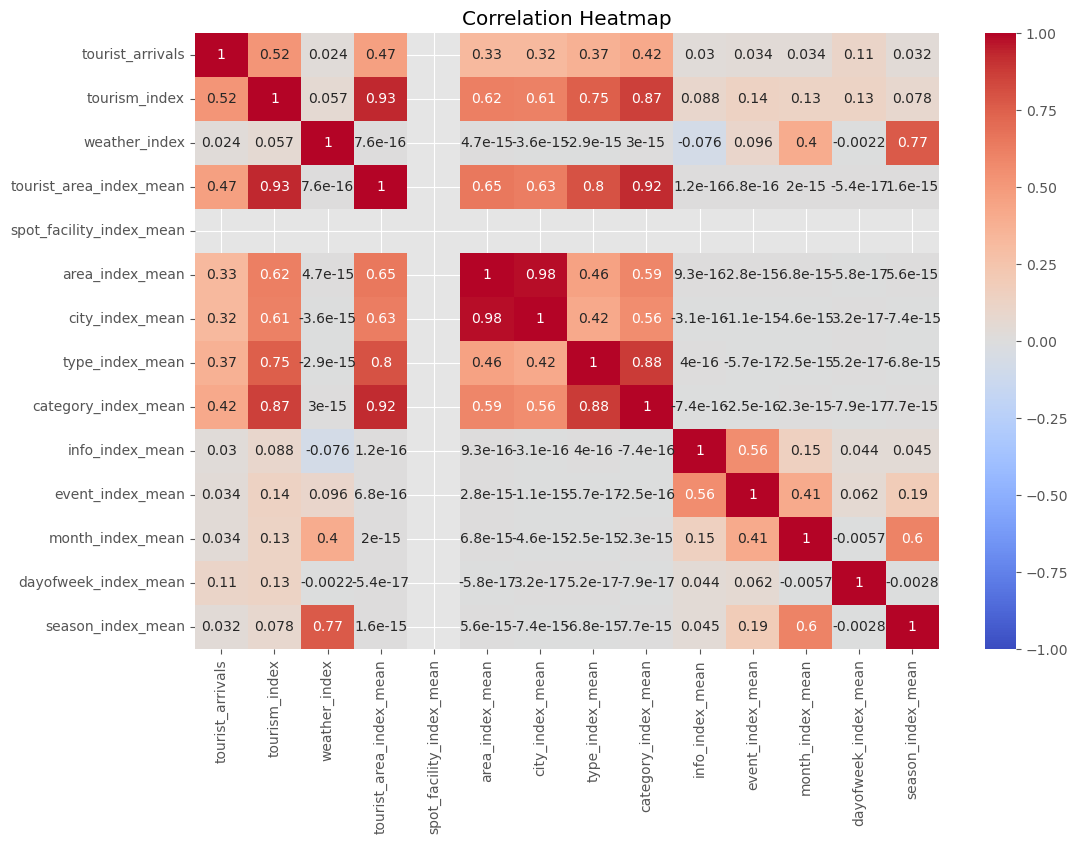

In [145]:
# target_encodingの特徴量探索
target_list = ['tourist_area', 'spot_facility','area', 'city', 'type', 'category','info', 'event', 'month','dayofweek', 'season']

# 特徴量ごとのtourism_indexの平均値
for target in target_list:
    train_index_mean = train_df.groupby(target)['tourism_index'].mean().reset_index()
    train_index_mean.rename(columns={'tourism_index': f'{target}_index_mean'}, inplace=True)
    train_df = pd.merge(train_df, train_index_mean, on=target, how='left')

    test_index_mean = test_df.groupby(target)['tourism_index'].mean().reset_index()
    test_index_mean.rename(columns={'tourism_index': f'{target}_index_mean'}, inplace=True)
    test_df = pd.merge(test_df, test_index_mean, on=target, how='left')

#相関行列の定義
features = ['tourist_arrivals', 'tourism_index', 'weather_index']+[f'{target}_index_mean' for target in target_list]
correlation_matrix = train_df[features].corr()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


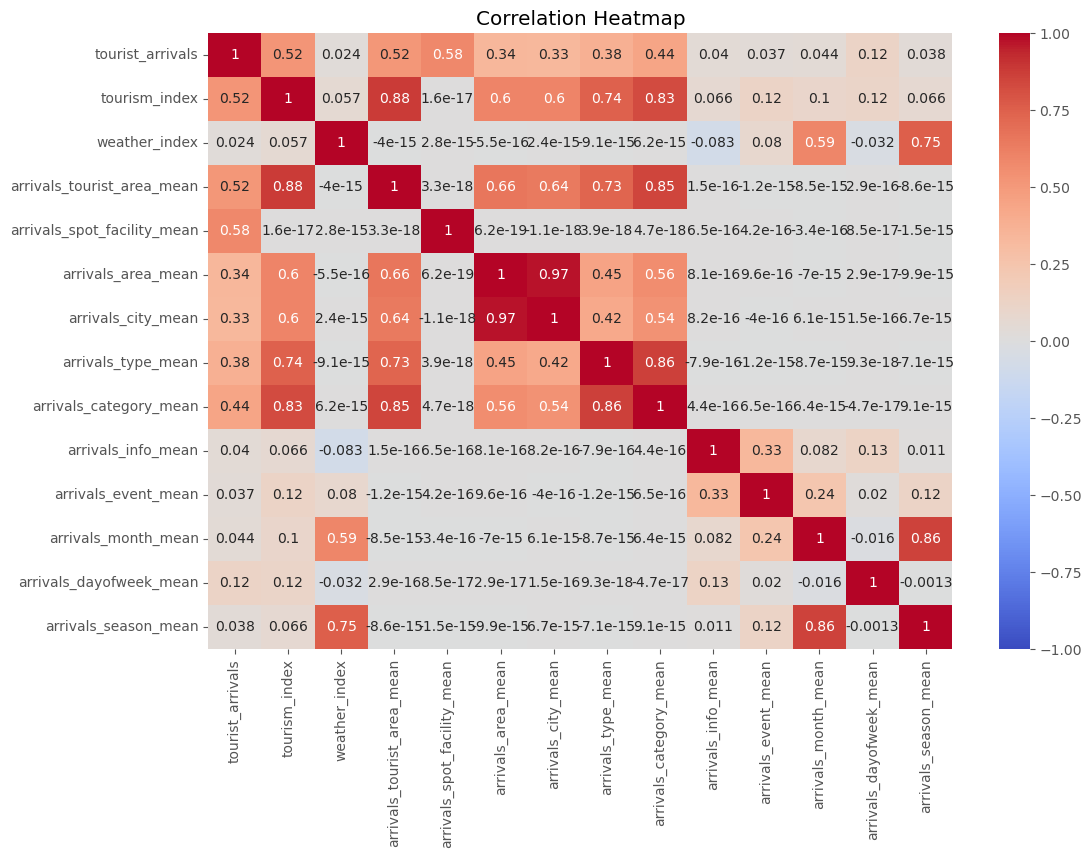

In [94]:
# target_encodingの特徴量探索
target_list = ['tourist_area', 'spot_facility','area', 'city', 'type', 'category','info', 'event', 'month','dayofweek', 'season']

# 特徴量ごとのtourist_arrivalsの平均値
for target in target_list:
    train_mean = train_df.groupby(target)['tourist_arrivals'].mean().reset_index()
    train_mean.rename(columns={'tourist_arrivals': f'arrivals_{target}_mean'}, inplace=True)
    train_df = pd.merge(train_df, train_mean, on=target, how='left')

#相関行列の定義
features = ['tourist_arrivals', 'tourism_index', 'weather_index']+[f'arrivals_{target}_mean' for target in target_list]
correlation_matrix = train_df[features].corr()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


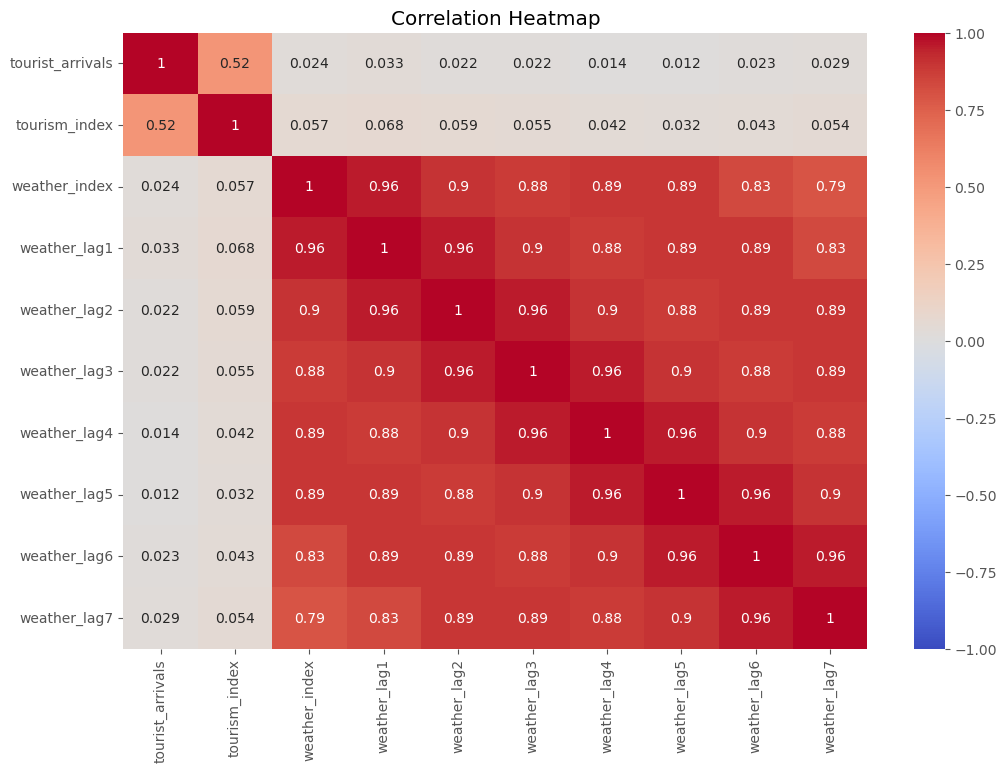

In [45]:
# weather_indexのラグ特徴量生成
for i in range(7):
    weather_obj = train_df.groupby(['date'])['weather_index'].mean().shift(i+1).reset_index()
    weather_obj.rename(columns={'weather_index': f'weather_lag{i+1}'}, inplace=True)
    train_df = pd.merge(train_df, weather_obj, how='left', on='date')

#相関行列の定義
features = ['tourist_arrivals', 'tourism_index', 'weather_index']+[f'weather_lag{i+1}' for i in range(7)]
correlation_matrix = train_df[features].corr()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

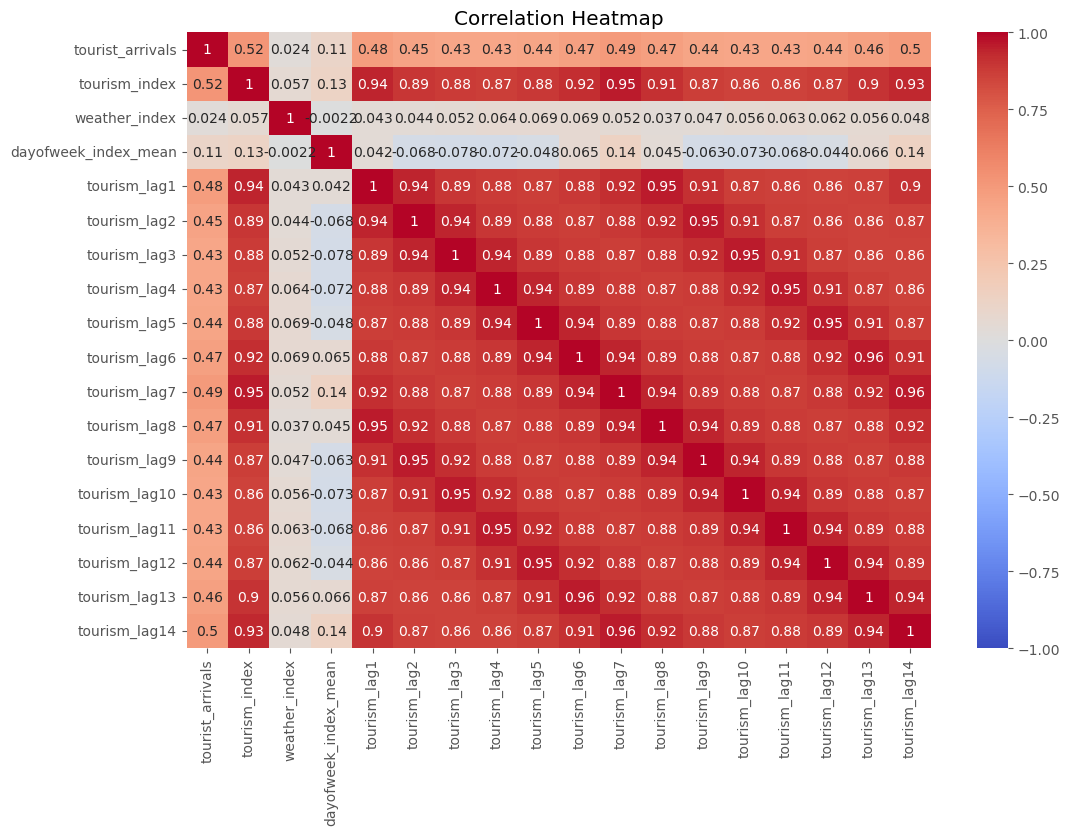

In [213]:
# tourism_indexのラグ特徴量生成
tourist_area_list = train_df['tourist_area'].unique().tolist()
tourism_obj = train_df.groupby(['date','tourist_area'])['tourism_index'].mean()

for i in range(14):
    for j in tourist_area_list:
        tourism_lag = tourism_obj.loc[(slice(None),j)].shift(i+1).reset_index()
        tourism_lag.rename(columns={'tourism_index': f'tourism_lag{i+1}_area{j}'}, inplace=True)
        tourism_lag['tourist_area'] = j
        train_df = pd.merge(train_df, tourism_lag, how='left', on=['date','tourist_area'])

    features = [f'tourism_lag{i+1}_area{j}' for j in tourist_area_list]
    train_df[f'tourism_lag{i+1}'] = train_df[features].bfill(axis=1).iloc[:, 0]
    train_df.drop(features, axis=1, inplace=True)

# dayofweek
train_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_index_mean)

#相関行列の定義
features = ['tourist_arrivals', 'tourism_index', 'weather_index', 'dayofweek_index_mean']+[f'tourism_lag{i+1}' for i in range(14)]
correlation_matrix = train_df[features].corr()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# ボツ

In [ ]:
# LGBMtuner:dart

# 目的変数と説明変数の設定 ###############################
y_train = train_df[['tourist_arrivals']]
x_train = train_df.drop(['id', 'date'], axis=1)
x_test = test_df.drop(['id', 'date'], axis=1)
category_list = x_train.columns[x_train.dtypes=='category'].values.tolist()
arrival_mean_list = ['spot_facility','area']

# ーーーー 交差検証(CV) ーーーー
# 学習データ：2018年8月1日 〜 2019年5月31日、検証データ：それぞれの月（評価データと同じ条件）
# 評価データ : 2019年7月1日 〜 2019年7月31日

# 学習用と検証用のRMSEを追加するリスト
train_list = []
val_list = []

# 学習後のモデルを格納するリスト
models = []
dart_params = []

month_index = x_train['month'].unique()   # 各月の数字を取得
for i, m in enumerate(month_index, 1):
    # 検証データの設定
    val_index = x_train[x_train["month"] == m].index   # インデックスを取得
    val_x_df = x_train.iloc[val_index]
    val_y_df = y_train.iloc[val_index]
    # 学習データの設定
    train_x_df = x_train.drop(val_index)   # 検証データのインデックスを落とす
    train_y_df = y_train.drop(val_index)

    # 目的変数に関する特徴量の追加(リークを避けるためにここで追加)
    # arrivals_mean_listごとの目的変数の平均値
    for feature in arrival_mean_list:
        train_obj = train_x_df.groupby(feature)['tourist_arrivals'].mean()   # 学習データの目的変数に関して求める
        train_x_df[f'arrivals_{feature}_mean'] = train_x_df[feature].map(train_obj)
        val_x_df[f'arrivals_{feature}_mean'] = val_x_df[feature].map(train_obj)
        x_test[f'arrivals_{feature}_mean'] = x_test[feature].map(train_obj)

    # 目的変数を落とす
    train_x_df = train_x_df.drop(['tourist_arrivals'], axis=1)
    val_x_df = val_x_df.drop(['tourist_arrivals'], axis=1)

    # optuna用に格納
    train_ds = lgb.Dataset(train_x_df, train_y_df)
    val_ds = lgb.Dataset(val_x_df, val_y_df)

    # パラメータ
    lgbm_params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'rmse',

    'learning_rate': 0.05,
    'n_estimators': 500,

    'random_seed': 42  # 乱数設定
    }

    # optunaによるパラメータチューニング
    opt = optuna_lgb.train(
        lgbm_params, train_ds, valid_sets=val_ds,
        verbose_eval = False,
        num_boost_round=100,
        early_stopping_rounds = 50,
        show_progress_bar=False,
        optuna_seed=42
        )

    # LightGBMREgressor()インスタンスの生成
    model = lgb.LGBMRegressor(**opt.params)
    model = model.fit(train_x_df, train_y_df,
        eval_set = [(train_x_df, train_y_df), (val_x_df, val_y_df)],
        early_stopping_rounds = 50,
        categorical_feature = category_list,
        verbose = -1
        )

    #作成したモデルの格納
    models.append(model)
    dart_params.append(opt.params)

    # predict
    y_pred_train_hold = model.predict(train_x_df, num_iteration=model.best_iteration_)
    y_pred_valid_hold = model.predict(val_x_df, num_iteration=model.best_iteration_)

    # RMSEを算出
    temp_rmse_train = np.sqrt(mean_squared_error(train_y_df, y_pred_train_hold))
    temp_rmse_valid = np.sqrt(mean_squared_error(val_y_df, y_pred_valid_hold))

    # RMSEの表示
    print(f'RMSE(train_data) = {temp_rmse_train:.4f}')
    print(f'RMSE(valid_data) = {temp_rmse_valid:.4f}\n')

    # 学習用データと検証用データのリスト
    train_list.append(temp_rmse_train)
    val_list.append(temp_rmse_valid)

    # 評価データで、実際に予測
    preds_test = model.predict(x_test, num_iteration=model.best_iteration_)
    preds_test_np = np.array(preds_test)

    # 予測値を出力
    submission_cv['tourist_arrivals' + '_model' + str(i)] = preds_test_np


In [ ]:
# 曜日単位でmodelを複数作成＆個別に予測させる

# 目的変数と説明変数の設定 ###############################
y_train = train_df[['tourist_arrivals']]
x_train = train_df.drop(['id', 'date'], axis=1)
x_test = test_df.drop(['id', 'date'], axis=1)
category_list = x_train.columns[x_train.dtypes=='category'].values.tolist()
arrival_mean_list = ['spot_facility','area']

# ーーーー 交差検証(CV) ーーーー
# 学習データ：2018年8月1日 〜 2019年4月30日、検証データ：評価データ : 2019年5月1日 〜 2019年5月31日
# 評価データ : 2019年7月1日 〜 2019年7月31日

# 学習用と検証用のRMSEを追加するリスト
train_list = []
val_list = []

# 学習後のモデルを格納するリスト
models = []

dayofweek_index = x_train['dayofweek'].unique()   # 各月の数字を取得
for w in dayofweek_index:
    # 検証データの設定
    val_index = x_train[(x_train["month"] == 5) & (x_train["dayofweek"] == w)].index   # インデックスを取得
    val_x_df = x_train.iloc[val_index]
    val_y_df = y_train.iloc[val_index]
    # 学習データの設定
    train_index = x_train[(x_train["month"] != 5) & (x_train["dayofweek"] == w)].index
    train_x_df = x_train.iloc[train_index]
    train_y_df = y_train.iloc[train_index]

    # 目的変数に関する特徴量の追加(リークを避けるためにここで追加)
    # arrivals_mean_listごとの目的変数の平均値
    for feature in arrival_mean_list:
        train_obj = train_x_df.groupby(feature)['tourist_arrivals'].mean()   # 学習データの目的変数に関して求める
        train_x_df[f'arrivals_{feature}_mean'] = train_x_df[feature].map(train_obj)
        val_x_df[f'arrivals_{feature}_mean'] = val_x_df[feature].map(train_obj)
        x_test[f'arrivals_{feature}_mean'] = x_test[feature].map(train_obj)

    # 目的変数を落とす
    train_x_df = train_x_df.drop(['tourist_arrivals'], axis=1)
    val_x_df = val_x_df.drop(['tourist_arrivals'], axis=1)

    # optuna用に格納
    train_ds = lgb.Dataset(train_x_df, train_y_df)
    val_ds = lgb.Dataset(val_x_df, val_y_df)

    # パラメータ
    lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'random_seed': 42  # 乱数設定
    }

    # optunaによるパラメータチューニング
    opt = optuna_lgb.train(
        lgbm_params, train_ds, valid_sets=val_ds,
        verbose_eval = False,
        num_boost_round=100,
        early_stopping_rounds = 50,
        show_progress_bar=False
        )

    # LightGBMREgressor()インスタンスの生成
    model = lgb.LGBMRegressor(**opt.params)
    model = model.fit(train_x_df, train_y_df,
        eval_set = [(train_x_df, train_y_df), (val_x_df, val_y_df)],
        early_stopping_rounds = 50,
        categorical_feature = category_list,
        verbose = -1
        )

    #作成したモデルの格納
    models.append(model)

    # predict
    y_pred_train_hold = model.predict(train_x_df, num_iteration=model.best_iteration_)
    y_pred_valid_hold = model.predict(val_x_df, num_iteration=model.best_iteration_)

    # RMSEを算出
    temp_rmse_train = np.sqrt(mean_squared_error(train_y_df, y_pred_train_hold))
    temp_rmse_valid = np.sqrt(mean_squared_error(val_y_df, y_pred_valid_hold))

    # RMSEの表示
    print(f'RMSE(train_data) = {temp_rmse_train:.4f}')
    print(f'RMSE(valid_data) = {temp_rmse_valid:.4f}\n')

    # 学習用データと検証用データのリスト
    train_list.append(temp_rmse_train)
    val_list.append(temp_rmse_valid)

    # 評価データで、実際に予測
    preds_test = model.predict(x_test[x_test["dayofweek"] == w], num_iteration=model.best_iteration_)
    preds_test_np = np.array(preds_test)

    # 予測値を出力
    submission.loc[x_test[x_test["dayofweek"] == w].index, 'tourist_arrivals'] = preds_test_np

# 学習用データと検証用データの予測精度を出力
for w in dayofweek_index:
    print(f'検証データ{w}曜日: RMSE(train_data) = {train_list[w]:.4f}, RMSE(valid_data) = {val_list[w]:.4f}')
print(f'train_fold_mean: {np.mean(train_list):.4f}, valid_fold_mean: {np.mean(val_list):.4f}')


In [ ]:
# 単体モデル作成
# 目的変数と説明変数の設定 ###############################
y_train = train_df[['tourist_arrivals']]
x_train = train_df.drop(['id', 'date'], axis=1)
x_test = test_df.drop(['id', 'date'], axis=1)
category_list = x_train.columns[x_train.dtypes=='category'].values.tolist()
arrival_mean_list = ['spot_facility','area']

# パラメータ
lgbm_params = {
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',

'learning_rate': 0.05,
'n_estimators': 3000,
'importance_type': 'gain',

'num_leaves': 32,

'min_data_in_leaf': 20,
'min_sum_hessian_in_leaf': 20,
'lambda_l1': 0.0,
'lambda_l2': 0.0,

'bagging_fraction': 0.9,
'bagging_freq': 1,
'feature_fraction': 0.9,

'random_seed': 42  # 乱数設定
}


#LightGBMREgressor()インスタンスの生成
model = lgb.LGBMRegressor(**lgbm_params)

# 検証データの設定
val_index = x_train[x_train["month"] == 5].index   # インデックスを取得
val_x_df = x_train.iloc[val_index]
val_y_df = y_train.iloc[val_index]

# 学習データの設定
train_x_df = x_train.drop(val_index)   # 検証データのインデックスを落とす
train_y_df = y_train.drop(val_index)

# 目的変数に関する特徴量の追加(リークを避けるためにここで追加)
# arrivals_mean_listごとの目的変数の平均値
for feature in arrival_mean_list:
    train_obj = train_x_df.groupby(feature)['tourist_arrivals'].mean()   # 学習データの目的変数に関して求める
    train_x_df[f'arrivals_{feature}_mean'] = train_x_df[feature].map(train_obj)
    val_x_df[f'arrivals_{feature}_mean'] = val_x_df[feature].map(train_obj)
    x_test[f'arrivals_{feature}_mean'] = x_test[feature].map(train_obj)

# 目的変数を落とす
train_x_df = train_x_df.drop(['tourist_arrivals'], axis=1)
val_x_df = val_x_df.drop(['tourist_arrivals'], axis=1)


# モデルのfitting
model.fit(train_x_df, train_y_df,
            eval_set = [(train_x_df, train_y_df), (val_x_df, val_y_df)],
            early_stopping_rounds = 50,
            categorical_feature = category_list,
            verbose = -1
            )

# predict
y_pred_train_hold = model.predict(train_x_df, num_iteration=model.best_iteration_)
y_pred_valid_hold = model.predict(val_x_df, num_iteration=model.best_iteration_)

# RMSEを算出
temp_rmse_train = np.sqrt(mean_squared_error(train_y_df, y_pred_train_hold))
temp_rmse_valid = np.sqrt(mean_squared_error(val_y_df, y_pred_valid_hold))

# RMSEの表示
print(f'RMSE(train_data) = {temp_rmse_train:.4f}')
print(f'RMSE(valid_data) = {temp_rmse_valid:.4f}\n')

# 学習用データと検証用データのリスト
train_list.append(temp_rmse_train)
val_list.append(temp_rmse_valid)

# 評価データで、実際に予測
preds_test = model.predict(x_test, num_iteration=model.best_iteration_)
preds_test_np = np.array(preds_test)

# 予測値を出力
submission['tourist_arrivals'] = preds_test_np
submission.to_csv('submission_single.csv', index=False)


In [ ]:
#weather_indexをtarget_encoding

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

#tourism_indexの平均値
index_mean_list = ['dayofweek']
for feature in index_mean_list:
    train_index_mean = train_df.groupby(feature)['tourism_index'].mean()
    train_df[f'{feature}_index_mean'] = train_df[feature].map(train_index_mean)
    test_index_mean = test_df.groupby(feature)['tourism_index'].mean()
    test_df[f'{feature}_index_mean'] = test_df[feature].map(test_index_mean)

#weather_indexの平均値
weather_mean_list = ['season']
for feature in weather_mean_list:
    train_weather_mean = train_df.groupby(feature)['weather_index'].mean()
    train_df[f'{feature}_weather_mean'] = train_df[feature].map(train_weather_mean)
    test_weather_mean = test_df.groupby(feature)['weather_index'].mean()
    test_df[f'{feature}_weather_mean'] = test_df[feature].map(test_weather_mean)

#カテゴリ化(label encoding)
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()
category_list += ['tourist_area', 'category']

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    le_train = LabelEncoder()
    le_train = le_train.fit(train_df[cat])

    train_df[cat] = le_train.transform(train_df[cat])
    test_df[cat] = le_train.transform(test_df[cat])

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
#Categoryをintで読み込ませる:75.19→77.74

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

#tourism_indexの平均値
index_mean_list = ['dayofweek']
for feature in index_mean_list:
    train_weekday_index_mean = train_df.groupby(feature)['tourism_index'].mean()
    train_df[f'{feature}_index_mean'] = train_df[feature].map(train_weekday_index_mean)
    test_weekday_index_mean = test_df.groupby(feature)['tourism_index'].mean()
    test_df[f'{feature}index_mean'] = test_df[feature].map(test_weekday_index_mean)

#カテゴリ化(label encoding)
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()
category_list += ['tourist_area', 'category']

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    le_train = LabelEncoder()
    le_train = le_train.fit(train_df[cat])

    train_df[cat] = le_train.transform(train_df[cat])
    test_df[cat] = le_train.transform(test_df[cat])

    train_df[cat] = train_df[cat].astype('int')
    test_df[cat] = test_df[cat].astype('int')


In [ ]:
#month,day,dayofweekをカテゴリ変換:75.19→76.86

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

# cityごとのtourism_indexの平均値
train_area_index_mean = train_df.groupby('month')['tourism_index'].mean()
train_df['month_index_mean'] = train_df['month'].map(train_area_index_mean)
test_area_index_mean = test_df.groupby('month')['tourism_index'].mean()
test_df['month_index_mean'] = test_df['month'].map(train_area_index_mean)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()
category_list += ['tourist_area', 'category', 'month', 'day', 'dayofweek']

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
#monthごとのtourism_indexの平均値:75.36→75.52

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

# cityごとのtourism_indexの平均値
train_area_index_mean = train_df.groupby('month')['tourism_index'].mean()
train_df['month_index_mean'] = train_df['month'].map(train_area_index_mean)
test_area_index_mean = test_df.groupby('month')['tourism_index'].mean()
test_df['month_index_mean'] = test_df['month'].map(train_area_index_mean)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()
category_list += ['tourist_area', 'category']

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
#Tourist_areaごとのtourism_indexの平均値:75.36→76.03

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

# Tourist_areaごとのtourism_indexの平均値
train_area_index_mean = train_df.groupby('tourist_area')['tourism_index'].mean()
train_df['area_index_mean'] = train_df['tourist_area'].map(train_area_index_mean)
test_area_index_mean = test_df.groupby('tourist_area')['tourism_index'].mean()
test_df['area_index_mean'] = test_df['tourist_area'].map(train_area_index_mean)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()
category_list += ['tourist_area', 'category']

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
#weather_indexの欠損値を各月の平均値で埋める：75.36→75.81

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

# weather_indexの平均値を欠損値に補填する
train_month_weather_index_mean = train_df.groupby('month')['weather_index'].mean()
train_df['weather_index'] = train_df.apply(
    lambda row: train_month_weather_index_mean[row['month']]
    if np.isnan(row['weather_index']) else row['weather_index'],axis=1)
test_month_weather_index_mean = test_df.groupby('month')['weather_index'].mean()
test_df['weather_index'] = test_df.apply(
    lambda row: test_month_weather_index_mean[row['month']]
    if np.isnan(row['weather_index']) else row['weather_index'],axis=1)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()
category_list += ['tourist_area', 'category']

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
#クリスマスフラグ(12/20-12/24)の追加：75.36→75.36

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

#christmas_flag
chirstmas_list = ['2018-12-20','2018-12-21','2018-12-22','2018-12-23','2018-12-24']
train_df['chirstmas'] = train_df['date'].apply(lambda x: 1 if x in chirstmas_list else 0)
test_df['chirstmas'] = test_df['date'].apply(lambda x: 1 if x in chirstmas_list else 0)


#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()
category_list += ['tourist_area', 'category', 'chirstmas']

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
#holiday_flag：75.36→75.44

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek
train_df['holiday'] = train_df['dayofweek'].isin([5,6]).astype('int')

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek
test_df['holiday'] = test_df['dayofweek'].isin([5,6]).astype('int')

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()


for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
#trainから12月データを除外する：75.98 → 78.24

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    elif month in (9, 10, 11):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')

train_df = train_df[train_df['month']!=12].reset_index(drop=True)


In [ ]:
# seasonをラベルエンコーディング＆三角関数特徴量化：76.8 → 78.12
#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (1, 2, 3):
        return 0
    elif month in (4, 5, 6):
        return 1
    elif month in (7, 8, 9):
        return 2
    else:
        return 3
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
train_df = encode(train_df, 'season')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')
test_df = encode(test_df, 'season')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
# seasonをラベルエンコーディングして学習させる：76.8→77.93
#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateから、month, day, weekdayの情報を生成(yearは生成しない)
# train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek

# monthから季節を抽出
def get_season(month):
    if month in (1, 2, 3):
        return 0
    elif month in (4, 5, 6):
        return 1
    elif month in (7, 8, 9):
        return 2
    else:
        return 3
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
#yearをすべて2019年に置換：77.72 → 88.57

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateのyearをすべて2019年に置換する
train_df['date'] =train_df['date'].apply(lambda x: x.replace(year=2019))
test_df['date'] =test_df['date'].apply(lambda x: x.replace(year=2019))

# dateから、year, month, dayの情報を生成
# 訓練データ
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# 予測対象データ
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek


# monthから季節を抽出
def get_season(month):
    if month in (1, 2, 3):
        return 'spring'
    elif month in (4, 5, 6):
        return 'summer'
    elif month in (7, 8, 9):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')


In [ ]:
#yearをすべて2018年に置換：77.72 → 88.23

#データ読み込み
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission = pd.read_csv('submission.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
submission_cv = submission.drop('tourist_arrivals', axis=1)

# dateのyearをすべて2018年に置換する
train_df['date'] =train_df['date'].apply(lambda x: x.replace(year=2018))
test_df['date'] =test_df['date'].apply(lambda x: x.replace(year=2018))

# dateから、year, month, dayの情報を生成
# 訓練データ
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# 予測対象データ
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek


# monthから季節を抽出
def get_season(month):
    if month in (1, 2, 3):
        return 'spring'
    elif month in (4, 5, 6):
        return 'summer'
    elif month in (7, 8, 9):
        return 'fall'
    else:
        return 'winter'
train_df['season'] = train_df.apply(lambda x: get_season(x['month']), axis=1)
test_df['season'] = test_df.apply(lambda x: get_season(x['month']), axis=1)

# 三角関数特徴量
def encode(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df
train_df = encode(train_df, 'month')
train_df = encode(train_df, 'day')
train_df = encode(train_df, 'dayofweek')
test_df = encode(test_df, 'month')
test_df = encode(test_df, 'day')
test_df = encode(test_df, 'dayofweek')

# dayofweekごとのtourism_indexの平均値
train_weekday_index_mean = train_df.groupby('dayofweek')['tourism_index'].mean()
train_df['dayofweek_index_mean'] = train_df['dayofweek'].map(train_weekday_index_mean)
test_weekday_index_mean = test_df.groupby('dayofweek')['tourism_index'].mean()
test_df['dayofweek_index_mean'] = test_df['dayofweek'].map(test_weekday_index_mean)

#カテゴリ化
category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()

for cat in category_list:
    train_df[cat] = train_df[cat].fillna('unknown')
    test_df[cat] = test_df[cat].fillna('unknown')

    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')
